# Loading data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

In [3]:
# Unzipping train_data

!unzip -uq "/content/drive/My Drive/Project3/train_data.zip" -d "/content/drive/My Drive/Project3"

In [5]:
# [DO NOT MODIFY THIS CELL]

# load the images
n_img = 50000
n_noisy = 40000
n_clean_noisy = n_img - n_noisy
imgs = np.empty((n_img,32,32,3))
for i in range(n_img):
    img_fn = f'/content/drive/My Drive/Project3/images/{i+1:05d}.png'
    imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)

# load the labels
clean_labels = np.genfromtxt('/content/drive/My Drive/Project3/clean_labels.csv', delimiter=',', dtype="int8")
noisy_labels = np.genfromtxt('/content/drive/My Drive/Project3/noisy_labels.csv', delimiter=',', dtype="int8")

Clean labels:
 frog truck truck  deer   car   car  bird horse
Noisy labels:
  cat   dog truck  frog   dog  ship  bird  deer


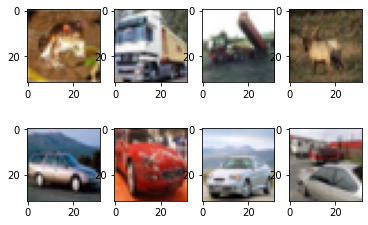

In [6]:
# [DO NOT MODIFY THIS CELL]

fig = plt.figure()

ax1 = fig.add_subplot(2,4,1)
ax1.imshow(imgs[0]/255)
ax2 = fig.add_subplot(2,4,2)
ax2.imshow(imgs[1]/255)
ax3 = fig.add_subplot(2,4,3)
ax3.imshow(imgs[2]/255)
ax4 = fig.add_subplot(2,4,4)
ax4.imshow(imgs[3]/255)
ax1 = fig.add_subplot(2,4,5)
ax1.imshow(imgs[4]/255)
ax2 = fig.add_subplot(2,4,6)
ax2.imshow(imgs[5]/255)
ax3 = fig.add_subplot(2,4,7)
ax3.imshow(imgs[49998]/255)
ax4 = fig.add_subplot(2,4,8)
ax4.imshow(imgs[49999]/255)

# The class-label correspondence
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# print clean labels
print('Clean labels:')
print(' '.join('%5s' % classes[clean_labels[j]] for j in range(8)))
# print noisy labels
print('Noisy labels:')
print(' '.join('%5s' % classes[noisy_labels[j]] for j in range(8)))

# XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

# Model 1 (Dense Net)

In [ ]:
X = imgs
y = noisy_labels

In [ ]:
# creating a training and test set

x_train, x_test, y_train, y_test=train_test_split(X,y,test_size=5000, random_state=42, stratify=y)

(x_train.shape, y_train.shape), (x_test.shape, y_test.shape)

(((45000, 32, 32, 3), (45000,)), ((5000, 32, 32, 3), (5000,)))

In [ ]:
# creating a training and validation set

x_train, x_val, y_train, y_val=train_test_split(x_train,y_train,test_size=5000, random_state=42, stratify=y_train)

(x_train.shape, y_train.shape), (x_val.shape, y_val.shape)

(((40000, 32, 32, 3), (40000,)), ((5000, 32, 32, 3), (5000,)))

In [ ]:
print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

((40000, 32, 32, 3), (40000,))
((5000, 32, 32, 3), (5000,))
((5000, 32, 32, 3), (5000,))


In [ ]:
import tensorflow.keras as K
import tensorflow as tf

In [ ]:
device_name = tf.test.gpu_device_name()
print(device_name)

/device:GPU:0


In [ ]:
# Pre-processing X and Y

def preprocess_data(X, Y):

    X_p = K.applications.densenet.preprocess_input(X)

    # encode to one-hot
    Y_p = K.utils.to_categorical(Y, 10)
    return X_p, Y_p

In [ ]:
# pre-procces data
x_train, y_train = preprocess_data(x_train, y_train)
x_val, y_val = preprocess_data(x_val, y_val)

In [ ]:
# Resizing images

inputs = K.Input(shape=(32, 32, 3))

# upscale layer
upscale = K.layers.Lambda(lambda x: tf.image.resize_with_pad(x, 224, 224, method=tf.image.ResizeMethod.BILINEAR))(inputs)

In [ ]:
# load base model
base_model = K.applications.DenseNet121(include_top=False,
                                        weights='imagenet',
                                        input_tensor=upscale,
                                        input_shape=(224,224,3),
                                        pooling='max')

In [ ]:
# add top layers
out = base_model.output
out = K.layers.Flatten()(out)
out = K.layers.BatchNormalization()(out)
out = K.layers.Dense(256, activation='relu')(out)
out = K.layers.Dropout(0.3)(out)
out = K.layers.BatchNormalization()(out)
out = K.layers.Dense(128, activation='relu')(out)
out = K.layers.Dropout(0.3)(out)
out = K.layers.BatchNormalization()(out)
out = K.layers.Dense(64, activation='relu')(out)
out = K.layers.Dropout(0.3)(out)
out = K.layers.Dense(10, activation='softmax')(out)

In [ ]:
CALLBACKS = []
MODEL_PATH = 'cifar10.h5'
optimizer = K.optimizers.Adam()

In [ ]:
# callbacks
CALLBACKS.append(K.callbacks.ModelCheckpoint(filepath=MODEL_PATH,
                                              monitor='val_accuracy',
                                              save_best_only=True))

CALLBACKS.append(K.callbacks.EarlyStopping(monitor='val_accuracy',
                                            verbose=1,
                                            patience=5))

CALLBACKS.append(K.callbacks.TensorBoard(log_dir='logs'))

In [ ]:
# model compile
model = K.models.Model(inputs=inputs, outputs=out)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 lambda_4 (Lambda)              (None, 224, 224, 3)  0           ['input_12[0][0]']               
                                                                                                  
 zero_padding2d_8 (ZeroPadding2  (None, 230, 230, 3)  0          ['lambda_4[0][0]']               
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_8[0][0]'] 

In [ ]:
# train
model.fit(x=x_train,
          y=y_train,
          batch_size=128,
          epochs=20,
          callbacks=CALLBACKS,
          validation_data=(x_val, y_val))

Epoch 1/20
313/313 [==============================] - 99s 264ms/step - loss: 2.4258 - accuracy: 0.1216 - val_loss: 2.2803 - val_accuracy: 0.1460
Epoch 2/20
313/313 [==============================] - 79s 252ms/step - loss: 2.2856 - accuracy: 0.1504 - val_loss: 2.2488 - val_accuracy: 0.1862
Epoch 3/20
313/313 [==============================] - 77s 247ms/step - loss: 2.2605 - accuracy: 0.1724 - val_loss: 2.2552 - val_accuracy: 0.1664
Epoch 4/20
313/313 [==============================] - 77s 247ms/step - loss: 2.2453 - accuracy: 0.1868 - val_loss: 2.2551 - val_accuracy: 0.1674
Epoch 5/20
313/313 [==============================] - 77s 247ms/step - loss: 2.2301 - accuracy: 0.2035 - val_loss: 2.2494 - val_accuracy: 0.1824
Epoch 6/20
313/313 [==============================] - 79s 251ms/step - loss: 2.2262 - accuracy: 0.2067 - val_loss: 2.2228 - val_accuracy: 0.2052
Epoch 7/20
313/313 [==============================] - 77s 247ms/step - loss: 2.2181 - accuracy: 0.2174 - val_loss: 2.2417 - val_ac

In [ ]:
# Test set X pre-processing:


def preprocess(X):

    X_p = K.applications.densenet.preprocess_input(X)

    return X_p

x_test  = preprocess(x_test)

In [ ]:
# Test set prediction:                     # Submit this "y_pred"

y_pred1 = model.predict(x_test)
y_pred = np.argmax(y_pred1,axis=1)

157/157 [==============================] - 6s 22ms/step


In [ ]:
# Test set Y pre-processing:             # Can't run this for final test set coz y_test is unavailable


def preprocess(Y):

    # encode to one-hot
    Y_p = K.utils.to_categorical(Y, 10)
    return Y_p

y_test  = preprocess(y_test)

In [ ]:
# Test Set accuracy                     # Can't run this for final test set coz y_test is unavailable

model.evaluate(x_test, y_test, batch_size=128, verbose=1)

40/40 [==============================] - 3s 66ms/step - loss: 2.1654 - accuracy: 0.2808


[2.1653552055358887, 0.2808000147342682]

# Model 2 (Efficient Net)

In [ ]:
X = imgs
y = noisy_labels

In [ ]:
# creating a training and test set

x_train, x_test, y_train, y_test=train_test_split(X,y,test_size=5000, random_state=42, stratify=y)

(x_train.shape, y_train.shape), (x_test.shape, y_test.shape)

(((45000, 32, 32, 3), (45000,)), ((5000, 32, 32, 3), (5000,)))

In [ ]:
# creating a training and validation set

x_train, x_val, y_train, y_val=train_test_split(x_train,y_train,test_size=5000, random_state=42, stratify=y_train)

(x_train.shape, y_train.shape), (x_val.shape, y_val.shape)

(((40000, 32, 32, 3), (40000,)), ((5000, 32, 32, 3), (5000,)))

In [ ]:
print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

((40000, 32, 32, 3), (40000,))
((5000, 32, 32, 3), (5000,))
((5000, 32, 32, 3), (5000,))


In [ ]:
import tensorflow.keras as K
import tensorflow as tf

In [ ]:
device_name = tf.test.gpu_device_name()
print(device_name)

/device:GPU:0


In [ ]:
# Pre-processing X and Y

def preprocess_data(X, Y):

    X_p = K.applications.efficientnet.preprocess_input(X)

    # encode to one-hot
    Y_p = K.utils.to_categorical(Y, 10)
    return X_p, Y_p

In [ ]:
# pre-procces data
x_train, y_train = preprocess_data(x_train, y_train)
x_val, y_val = preprocess_data(x_val, y_val)

In [ ]:
# Resizing images

inputs = K.Input(shape=(32, 32, 3))

# upscale layer
upscale = K.layers.Lambda(lambda x: tf.image.resize_with_pad(x, 224, 224, method=tf.image.ResizeMethod.BILINEAR))(inputs)

In [ ]:
# load base model
base_model = K.applications.EfficientNetB0(include_top=False,
                                        weights='imagenet',
                                        input_tensor=upscale,
                                        input_shape=(224,224,3),
                                        pooling='max')

In [ ]:
# add top layers
out = base_model.output
out = K.layers.Flatten()(out)
out = K.layers.BatchNormalization()(out)
out = K.layers.Dense(256, activation='relu')(out)
out = K.layers.Dropout(0.3)(out)
out = K.layers.BatchNormalization()(out)
out = K.layers.Dense(128, activation='relu')(out)
out = K.layers.Dropout(0.3)(out)
out = K.layers.BatchNormalization()(out)
out = K.layers.Dense(64, activation='relu')(out)
out = K.layers.Dropout(0.3)(out)
out = K.layers.Dense(10, activation='softmax')(out)

In [ ]:
CALLBACKS = []
MODEL_PATH = 'cifar10.h5'
optimizer = K.optimizers.Adam()

In [ ]:
# callbacks
CALLBACKS.append(K.callbacks.ModelCheckpoint(filepath=MODEL_PATH,
                                              monitor='val_accuracy',
                                              save_best_only=True))

CALLBACKS.append(K.callbacks.EarlyStopping(monitor='val_accuracy',
                                            verbose=1,
                                            patience=5))

CALLBACKS.append(K.callbacks.TensorBoard(log_dir='logs'))

In [ ]:
# model compile
model = K.models.Model(inputs=inputs, outputs=out)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 lambda_6 (Lambda)              (None, 224, 224, 3)  0           ['input_14[0][0]']               
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['lambda_6[0][0]']               
                                                                                                  
 normalization_1 (Normalization  (None, 224, 224, 3)  7          ['rescaling_1[0][0]']            
 )                                                                                          

In [ ]:
# train
model.fit(x=x_train,
          y=y_train,
          batch_size=128,
          epochs=10,
          callbacks=CALLBACKS,
          validation_data=(x_val, y_val))

Epoch 1/20
313/313 [==============================] - 228s 695ms/step - loss: 2.3662 - accuracy: 0.1873 - val_loss: 2.1534 - val_accuracy: 0.3002
Epoch 2/20
313/313 [==============================] - 210s 670ms/step - loss: 2.1687 - accuracy: 0.2957 - val_loss: 2.1026 - val_accuracy: 0.3316
Epoch 3/20
313/313 [==============================] - 200s 638ms/step - loss: 2.1072 - accuracy: 0.3417 - val_loss: 2.0916 - val_accuracy: 0.3410
Epoch 4/20
313/313 [==============================] - 200s 639ms/step - loss: 2.0753 - accuracy: 0.3563 - val_loss: 2.0879 - val_accuracy: 0.3352
Epoch 5/20
313/313 [==============================] - 197s 628ms/step - loss: 2.0498 - accuracy: 0.3669 - val_loss: 2.1238 - val_accuracy: 0.3082
Epoch 6/20
313/313 [==============================] - 194s 619ms/step - loss: 2.0251 - accuracy: 0.3765 - val_loss: 2.1106 - val_accuracy: 0.3262
Epoch 7/20
313/313 [==============================] - 200s 640ms/step - loss: 1.9949 - accuracy: 0.3862 - val_loss: 2.1400 -

In [ ]:
# Test set X pre-processing:


def preprocess(X):

    X_p = K.applications.efficientnet.preprocess_input(X)

    return X_p

x_test  = preprocess(x_test)

In [ ]:
# Test set prediction:                     # Submit this "y_pred"

y_pred1 = model.predict(x_test)
y_pred = np.argmax(y_pred1,axis=1)

157/157 [==============================] - 4s 14ms/step


In [ ]:
# Test set Y pre-processing:             # Can't run this for final test set coz y_test is unavailable


def preprocess(Y):

    # encode to one-hot
    Y_p = K.utils.to_categorical(Y, 10)
    return Y_p

y_test  = preprocess(y_test)

In [ ]:
# Test Set accuracy                     # Can't run this for final test set coz y_test is unavailable

model.evaluate(x_test, y_test, batch_size=128, verbose=1)

40/40 [==============================] - 2s 44ms/step - loss: 2.1870 - accuracy: 0.2914


[2.1870462894439697, 0.2913999855518341]

# Model 3 (Model 2 + Image Augmentation)

In [ ]:
X = imgs
y = noisy_labels

In [ ]:
# creating a training and test set

x_train, x_test, y_train, y_test=train_test_split(X,y,test_size=5000, random_state=42, stratify=y)

(x_train.shape, y_train.shape), (x_test.shape, y_test.shape)

(((45000, 32, 32, 3), (45000,)), ((5000, 32, 32, 3), (5000,)))

In [ ]:
# creating a training and validation set

x_train, x_val, y_train, y_val=train_test_split(x_train,y_train,test_size=5000, random_state=42, stratify=y_train)

(x_train.shape, y_train.shape), (x_val.shape, y_val.shape)

(((40000, 32, 32, 3), (40000,)), ((5000, 32, 32, 3), (5000,)))

In [ ]:
print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

((40000, 32, 32, 3), (40000,))
((5000, 32, 32, 3), (5000,))
((5000, 32, 32, 3), (5000,))


In [ ]:
import tensorflow.keras as K
import tensorflow as tf

In [ ]:
device_name = tf.test.gpu_device_name()
print(device_name)

/device:GPU:0


In [ ]:
# set up image augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
    #zoom_range=0.3
    )
datagen.fit(x_train)

In [ ]:
# Pre-processing X and Y

def preprocess_data(X, Y):

    X_p = K.applications.efficientnet.preprocess_input(X)

    # encode to one-hot
    Y_p = K.utils.to_categorical(Y, 10)
    return X_p, Y_p

In [ ]:
# pre-procces data
x_train, y_train = preprocess_data(x_train, y_train)
x_val, y_val = preprocess_data(x_val, y_val)

In [ ]:
# Resizing images

inputs = K.Input(shape=(32, 32, 3))

# upscale layer
upscale = K.layers.Lambda(lambda x: tf.image.resize_with_pad(x, 224, 224, method=tf.image.ResizeMethod.BILINEAR))(inputs)

In [ ]:
# load base model
base_model = K.applications.EfficientNetB0(include_top=False,
                                        weights='imagenet',
                                        input_tensor=upscale,
                                        input_shape=(224,224,3),
                                        pooling='max')

In [ ]:
# add top layers
out = base_model.output
out = K.layers.Flatten()(out)
out = K.layers.BatchNormalization()(out)
out = K.layers.Dense(256, activation='relu')(out)
out = K.layers.Dropout(0.3)(out)
out = K.layers.BatchNormalization()(out)
out = K.layers.Dense(128, activation='relu')(out)
out = K.layers.Dropout(0.3)(out)
out = K.layers.BatchNormalization()(out)
out = K.layers.Dense(64, activation='relu')(out)
out = K.layers.Dropout(0.3)(out)
out = K.layers.Dense(10, activation='softmax')(out)

In [ ]:
CALLBACKS = []
MODEL_PATH = 'cifar10.h5'
optimizer = K.optimizers.Adam()

In [ ]:
# callbacks
CALLBACKS.append(K.callbacks.ModelCheckpoint(filepath=MODEL_PATH,
                                              monitor='val_accuracy',
                                              save_best_only=True))

CALLBACKS.append(K.callbacks.EarlyStopping(monitor='val_accuracy',
                                            verbose=1,
                                            patience=5))

CALLBACKS.append(K.callbacks.TensorBoard(log_dir='logs'))

In [ ]:
# model compile
model = K.models.Model(inputs=inputs, outputs=out)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 lambda_8 (Lambda)              (None, 224, 224, 3)  0           ['input_16[0][0]']               
                                                                                                  
 rescaling_3 (Rescaling)        (None, 224, 224, 3)  0           ['lambda_8[0][0]']               
                                                                                                  
 normalization_3 (Normalization  (None, 224, 224, 3)  7          ['rescaling_3[0][0]']            
 )                                                                                          

In [ ]:
# train
model.fit_generator(datagen.flow(x=x_train,
          y=y_train,
          batch_size=128),steps_per_epoch = len(x_train) / 128,
          epochs=10,
          callbacks=CALLBACKS,
          validation_data=(x_val, y_val))

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


312/312 [==============================] - 219s 665ms/step - loss: 2.3781 - accuracy: 0.1727 - val_loss: 2.1960 - val_accuracy: 0.2438
Epoch 2/10
312/312 [==============================] - 207s 663ms/step - loss: 2.1967 - accuracy: 0.2608 - val_loss: 2.1529 - val_accuracy: 0.2998
Epoch 3/10
312/312 [==============================] - 207s 662ms/step - loss: 2.1485 - accuracy: 0.3088 - val_loss: 2.1013 - val_accuracy: 0.3262
Epoch 4/10
312/312 [==============================] - 206s 659ms/step - loss: 2.1151 - accuracy: 0.3304 - val_loss: 2.0743 - val_accuracy: 0.3458
Epoch 5/10
312/312 [==============================] - 200s 640ms/step - loss: 2.0963 - accuracy: 0.3419 - val_loss: 2.0859 - val_accuracy: 0.3342
Epoch 6/10
312/312 [==============================] - 204s 651ms/step - loss: 2.0851 - accuracy: 0.3476 - val_loss: 2.0879 - val_accuracy: 0.3322
Epoch 7/10
312/312 [==============================] - 200s 639ms/step - loss: 2.0725 - accuracy: 0.3541 - val_loss: 2.0761 - val_accura

In [ ]:
# Test set X pre-processing:


def preprocess(X):

    X_p = K.applications.efficientnet.preprocess_input(X)

    return X_p

x_test  = preprocess(x_test)

In [ ]:
# Test set prediction:                     # Submit this "y_pred"

y_pred1 = model.predict(x_test)
y_pred = np.argmax(y_pred1,axis=1)

157/157 [==============================] - 4s 14ms/step


In [ ]:
# Test set Y pre-processing:             # Can't run this for final test set coz y_test is unavailable


def preprocess(Y):

    # encode to one-hot
    Y_p = K.utils.to_categorical(Y, 10)
    return Y_p

y_test  = preprocess(y_test)

In [ ]:
# Test Set accuracy                     # Can't run this for final test set coz y_test is unavailable

model.evaluate(x_test, y_test, batch_size=128, verbose=1)

40/40 [==============================] - 2s 45ms/step - loss: 2.0760 - accuracy: 0.3446


[2.075974941253662, 0.34459999203681946]

# Model 4 (Model 3 + Unfreeze 20 Efficient Net layers - 3 top layers)

In [ ]:
X = imgs
y = noisy_labels

In [ ]:
# creating a training and test set

x_train, x_test, y_train, y_test=train_test_split(X,y,test_size=5000, random_state=42, stratify=y)

(x_train.shape, y_train.shape), (x_test.shape, y_test.shape)

(((45000, 32, 32, 3), (45000,)), ((5000, 32, 32, 3), (5000,)))

In [ ]:
# creating a training and validation set

x_train, x_val, y_train, y_val=train_test_split(x_train,y_train,test_size=5000, random_state=42, stratify=y_train)

(x_train.shape, y_train.shape), (x_val.shape, y_val.shape)

(((40000, 32, 32, 3), (40000,)), ((5000, 32, 32, 3), (5000,)))

In [ ]:
print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

((40000, 32, 32, 3), (40000,))
((5000, 32, 32, 3), (5000,))
((5000, 32, 32, 3), (5000,))


In [ ]:
import tensorflow.keras as K
import tensorflow as tf

In [ ]:
device_name = tf.test.gpu_device_name()
print(device_name)

/device:GPU:0


In [ ]:
# set up image augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
    #zoom_range=0.3
    )
datagen.fit(x_train)

In [ ]:
# Pre-processing X and Y

def preprocess_data(X, Y):

    X_p = K.applications.efficientnet.preprocess_input(X)

    # encode to one-hot
    Y_p = K.utils.to_categorical(Y, 10)
    return X_p, Y_p

In [ ]:
# pre-procces data
x_train, y_train = preprocess_data(x_train, y_train)
x_val, y_val = preprocess_data(x_val, y_val)

In [ ]:
# Resizing images

inputs = K.Input(shape=(32, 32, 3))

# upscale layer
upscale = K.layers.Lambda(lambda x: tf.image.resize_with_pad(x, 224, 224, method=tf.image.ResizeMethod.BILINEAR))(inputs)

In [ ]:
# load base model
base_model = K.applications.EfficientNetB0(include_top=False,
                                        weights='imagenet',
                                        input_tensor=upscale,
                                        input_shape=(224,224,3),
                                        pooling='max')

In [ ]:
# add top layers
out = base_model.output
out = K.layers.Flatten()(out)
out = K.layers.BatchNormalization()(out)
# out = K.layers.Dense(256, activation='relu')(out)
# out = K.layers.Dropout(0.3)(out)
# out = K.layers.BatchNormalization()(out)
out = K.layers.Dense(128, activation='relu')(out)
out = K.layers.Dropout(0.3)(out)
out = K.layers.BatchNormalization()(out)
out = K.layers.Dense(64, activation='relu')(out)
out = K.layers.Dropout(0.3)(out)
out = K.layers.Dense(10, activation='softmax')(out)

In [ ]:
CALLBACKS = []
MODEL_PATH = 'cifar10.h5'
optimizer = K.optimizers.Adam()

In [ ]:
# callbacks
CALLBACKS.append(K.callbacks.ModelCheckpoint(filepath=MODEL_PATH,
                                              monitor='val_accuracy',
                                              save_best_only=True))

CALLBACKS.append(K.callbacks.EarlyStopping(monitor='val_accuracy',
                                            verbose=1,
                                            patience=5))

CALLBACKS.append(K.callbacks.TensorBoard(log_dir='logs'))

In [ ]:
model = K.models.Model(inputs=inputs, outputs=out)

In [ ]:
from tensorflow.keras import layers 

def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )

In [ ]:
unfreeze_model(model)

In [ ]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 lambda_10 (Lambda)             (None, 224, 224, 3)  0           ['input_18[0][0]']               
                                                                                                  
 rescaling_5 (Rescaling)        (None, 224, 224, 3)  0           ['lambda_10[0][0]']              
                                                                                                  
 normalization_5 (Normalization  (None, 224, 224, 3)  7          ['rescaling_5[0][0]']            
 )                                                                                          

In [ ]:
# train
model.fit_generator(datagen.flow(x=x_train,
          y=y_train,
          batch_size=128),steps_per_epoch = len(x_train) / 128,
          epochs=10,
          callbacks=CALLBACKS,
          validation_data=(x_val, y_val))

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


312/312 [==============================] - 222s 680ms/step - loss: 2.6129 - accuracy: 0.1399 - val_loss: 2.2458 - val_accuracy: 0.2660
Epoch 2/10
312/312 [==============================] - 211s 675ms/step - loss: 2.3848 - accuracy: 0.1929 - val_loss: 2.1808 - val_accuracy: 0.2866
Epoch 3/10
312/312 [==============================] - 211s 675ms/step - loss: 2.3052 - accuracy: 0.2217 - val_loss: 2.1437 - val_accuracy: 0.3108
Epoch 4/10
312/312 [==============================] - 209s 669ms/step - loss: 2.2414 - accuracy: 0.2483 - val_loss: 2.1238 - val_accuracy: 0.3296
Epoch 5/10
312/312 [==============================] - 209s 669ms/step - loss: 2.2110 - accuracy: 0.2722 - val_loss: 2.1075 - val_accuracy: 0.3346
Epoch 6/10
312/312 [==============================] - 209s 668ms/step - loss: 2.1781 - accuracy: 0.2940 - val_loss: 2.0939 - val_accuracy: 0.3414
Epoch 7/10
312/312 [==============================] - 214s 684ms/step - loss: 2.1617 - accuracy: 0.2998 - val_loss: 2.0863 - val_accura

In [ ]:
# Test set X pre-processing:


def preprocess(X):

    X_p = K.applications.efficientnet.preprocess_input(X)

    return X_p

x_test  = preprocess(x_test)

In [ ]:
# Test set prediction:                     # Submit this "y_pred"

y_pred1 = model.predict(x_test)
y_pred = np.argmax(y_pred1,axis=1)

157/157 [==============================] - 4s 14ms/step


In [ ]:
# Test set Y pre-processing:             # Can't run this for final test set coz y_test is unavailable


def preprocess(Y):

    # encode to one-hot
    Y_p = K.utils.to_categorical(Y, 10)
    return Y_p

y_test  = preprocess(y_test)

In [ ]:
# Test Set accuracy                     # Can't run this for final test set coz y_test is unavailable

model.evaluate(x_test, y_test, batch_size=128, verbose=1)

40/40 [==============================] - 2s 44ms/step - loss: 2.0735 - accuracy: 0.3564


[2.0734593868255615, 0.3564000129699707]

# Model 5: (Model 4 + Add ReduceLROnPlateau + Increase epochs to 20)

In [29]:
X = imgs
y = noisy_labels

In [30]:
# creating a training and test set

x_train, x_test, y_train, y_test=train_test_split(X,y,test_size=5000, random_state=42, stratify=y)

(x_train.shape, y_train.shape), (x_test.shape, y_test.shape)

(((45000, 32, 32, 3), (45000,)), ((5000, 32, 32, 3), (5000,)))

In [31]:
# creating a training and validation set

x_train, x_val, y_train, y_val=train_test_split(x_train,y_train,test_size=5000, random_state=42, stratify=y_train)

(x_train.shape, y_train.shape), (x_val.shape, y_val.shape)

(((40000, 32, 32, 3), (40000,)), ((5000, 32, 32, 3), (5000,)))

In [32]:
print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

((40000, 32, 32, 3), (40000,))
((5000, 32, 32, 3), (5000,))
((5000, 32, 32, 3), (5000,))


In [33]:
import tensorflow.keras as K
import tensorflow as tf

In [34]:
device_name = tf.test.gpu_device_name()
print(device_name)

/device:GPU:0


In [35]:
# set up image augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
    #zoom_range=0.3
    )
datagen.fit(x_train)

In [36]:
# Pre-processing X and Y

def preprocess_data(X, Y):

    X_p = K.applications.efficientnet.preprocess_input(X)

    # encode to one-hot
    Y_p = K.utils.to_categorical(Y, 10)
    return X_p, Y_p

In [37]:
# pre-procces data
x_train, y_train = preprocess_data(x_train, y_train)
x_val, y_val = preprocess_data(x_val, y_val)

In [38]:
# Resizing images

inputs = K.Input(shape=(32, 32, 3))

# upscale layer
upscale = K.layers.Lambda(lambda x: tf.image.resize_with_pad(x, 224, 224, method=tf.image.ResizeMethod.BILINEAR))(inputs)

In [39]:
# load base model
base_model = K.applications.EfficientNetB0(include_top=False,
                                        weights='imagenet',
                                        input_tensor=upscale,
                                        input_shape=(224,224,3),
                                        pooling='max')

16705208/16705208 [==============================] - 0s 0us/step


In [40]:
# add top layers
out = base_model.output
out = K.layers.Flatten()(out)
out = K.layers.BatchNormalization()(out)
# out = K.layers.Dense(256, activation='relu')(out)
# out = K.layers.Dropout(0.3)(out)
# out = K.layers.BatchNormalization()(out)
out = K.layers.Dense(128, activation='relu')(out)
out = K.layers.Dropout(0.3)(out)
out = K.layers.BatchNormalization()(out)
out = K.layers.Dense(64, activation='relu')(out)
out = K.layers.Dropout(0.3)(out)
out = K.layers.Dense(10, activation='softmax')(out)

In [41]:
CALLBACKS = []
MODEL_PATH = 'cifar10.h5'
optimizer = K.optimizers.Adam()

In [42]:
# callbacks
CALLBACKS.append(K.callbacks.ModelCheckpoint(filepath=MODEL_PATH,
                                              monitor='val_accuracy',
                                              save_best_only=True))

CALLBACKS.append(K.callbacks.EarlyStopping(monitor='val_accuracy',
                                            verbose=1,
                                            patience=5))

CALLBACKS.append(K.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                            factor=0.2,
                                            patience=2))

CALLBACKS.append(K.callbacks.TensorBoard(log_dir='logs'))

In [43]:
model = K.models.Model(inputs=inputs, outputs=out)

In [44]:
from tensorflow.keras import layers 

def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )

In [45]:
unfreeze_model(model)

In [46]:
# train
model.fit_generator(datagen.flow(x=x_train,
          y=y_train,
          batch_size=128),steps_per_epoch = len(x_train) / 128,
          epochs=20,
          callbacks=CALLBACKS,
          validation_data=(x_val, y_val))

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


312/312 [==============================] - 227s 691ms/step - loss: 2.6235 - accuracy: 0.1338 - val_loss: 2.2755 - val_accuracy: 0.2378 - lr: 1.0000e-04
Epoch 2/20
312/312 [==============================] - 210s 673ms/step - loss: 2.3857 - accuracy: 0.1897 - val_loss: 2.1784 - val_accuracy: 0.2806 - lr: 1.0000e-04
Epoch 3/20
312/312 [==============================] - 209s 668ms/step - loss: 2.2950 - accuracy: 0.2213 - val_loss: 2.1372 - val_accuracy: 0.3046 - lr: 1.0000e-04
Epoch 4/20
312/312 [==============================] - 208s 665ms/step - loss: 2.2433 - accuracy: 0.2469 - val_loss: 2.1219 - val_accuracy: 0.3210 - lr: 1.0000e-04
Epoch 5/20
312/312 [==============================] - 210s 671ms/step - loss: 2.2040 - accuracy: 0.2710 - val_loss: 2.1087 - val_accuracy: 0.3354 - lr: 1.0000e-04
Epoch 6/20
312/312 [==============================] - 208s 665ms/step - loss: 2.1758 - accuracy: 0.2922 - val_loss: 2.1047 - val_accuracy: 0.3422 - lr: 1.0000e-04
Epoch 7/20
312/312 [=============

In [47]:
# Test set X pre-processing:


def preprocess(X):

    X_p = K.applications.efficientnet.preprocess_input(X)

    return X_p

x_test  = preprocess(x_test)

In [48]:
# Test set prediction:                     # Submit this "y_pred"

y_pred1 = model.predict(x_test)
y_pred = np.argmax(y_pred1,axis=1)

157/157 [==============================] - 4s 14ms/step


In [49]:
# Test set Y pre-processing:             # Can't run this for final test set coz y_test is unavailable


def preprocess(Y):

    # encode to one-hot
    Y_p = K.utils.to_categorical(Y, 10)
    return Y_p

y_test  = preprocess(y_test)

In [50]:
# Test Set accuracy                     # Can't run this for final test set coz y_test is unavailable

model.evaluate(x_test, y_test, batch_size=128, verbose=1)

40/40 [==============================] - 2s 43ms/step - loss: 2.0728 - accuracy: 0.3632


[2.072782278060913, 0.36320000886917114]

# Model 6 ( Model 5 + Image Super Resolution) (Takes too much time.Stick with Model 5)





In [ ]:
X = imgs
y = noisy_labels

In [ ]:
# creating a training and test set

x_train, x_test, y_train, y_test=train_test_split(X,y,test_size=5000, random_state=42, stratify=y)

(x_train.shape, y_train.shape), (x_test.shape, y_test.shape)

(((45000, 32, 32, 3), (45000,)), ((5000, 32, 32, 3), (5000,)))

In [ ]:
# creating a training and validation set

x_train, x_val, y_train, y_val=train_test_split(x_train,y_train,test_size=5000, random_state=42, stratify=y_train)

(x_train.shape, y_train.shape), (x_val.shape, y_val.shape)

(((40000, 32, 32, 3), (40000,)), ((5000, 32, 32, 3), (5000,)))

In [ ]:
print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

((40000, 32, 32, 3), (40000,))
((5000, 32, 32, 3), (5000,))
((5000, 32, 32, 3), (5000,))


In [ ]:
import tensorflow.keras as K
import tensorflow as tf

In [ ]:
device_name = tf.test.gpu_device_name()
print(device_name)

/device:GPU:0


In [ ]:
################### Image Enchancement:

In [ ]:
model = hub.load("https://tfhub.dev/captain-pool/esrgan-tf2/1")
concrete_func = model.signatures[tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]

@tf.function(input_signature=[tf.TensorSpec(shape=[1, 32, 32, 3], dtype=tf.float32)])
def f(input):
  return concrete_func(input);

converter = tf.lite.TFLiteConverter.from_concrete_functions([f.get_concrete_function()], model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the TF Lite model.
with tf.io.gfile.GFile('ESRGAN.tflite', 'wb') as f:
  f.write(tflite_model)

esrgan_model_path = './ESRGAN.tflite'

In [ ]:
lr = x_train

In [ ]:
temp = []

for i in range(len(x_train)):
  lr = x_train[i]
  # lr = tf.io.read_file(test_img_path)
  #lr = tf.image.decode_jpeg(lr)
  lr = tf.expand_dims(lr, axis=0)
  lr = tf.cast(lr, tf.float32)

  # Load TFLite model and allocate tensors.
  interpreter = tf.lite.Interpreter(model_path=esrgan_model_path)
  interpreter.allocate_tensors()

  # Get input and output tensors.
  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()

  # Run the model
  interpreter.set_tensor(input_details[0]['index'], lr)
  interpreter.invoke()

  # Extract the output and postprocess it
  output_data = interpreter.get_tensor(output_details[0]['index'])
  sr = tf.squeeze(output_data, axis=0)
  sr = tf.clip_by_value(sr, 0, 255)
  sr = tf.round(sr)
  sr = tf.cast(sr, tf.uint8)  
  temp.append(sr)

KeyboardInterrupt: ignored

In [ ]:
x_train = temp

In [ ]:
#########################################################################################################

In [ ]:
# set up image augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
    #zoom_range=0.3
    )
datagen.fit(x_train)

In [ ]:
# Pre-processing X and Y

def preprocess_data(X, Y):

    X_p = K.applications.efficientnet.preprocess_input(X)

    # encode to one-hot
    Y_p = K.utils.to_categorical(Y, 10)
    return X_p, Y_p

In [ ]:
# pre-procces data
x_train, y_train = preprocess_data(x_train, y_train)
x_val, y_val = preprocess_data(x_val, y_val)

In [ ]:
# Resizing images

inputs = K.Input(shape=(128, 128, 3))

# upscale layer
upscale = K.layers.Lambda(lambda x: tf.image.resize_with_pad(x, 224, 224, method=tf.image.ResizeMethod.BILINEAR))(inputs)

In [ ]:
# load base model
base_model = K.applications.EfficientNetB0(include_top=False,
                                        weights='imagenet',
                                        input_tensor=upscale,
                                        input_shape=(224,224,3),
                                        pooling='max')

In [ ]:
# add top layers
out = base_model.output
out = K.layers.Flatten()(out)
out = K.layers.BatchNormalization()(out)
# out = K.layers.Dense(256, activation='relu')(out)
# out = K.layers.Dropout(0.3)(out)
# out = K.layers.BatchNormalization()(out)
out = K.layers.Dense(128, activation='relu')(out)
out = K.layers.Dropout(0.3)(out)
out = K.layers.BatchNormalization()(out)
out = K.layers.Dense(64, activation='relu')(out)
out = K.layers.Dropout(0.3)(out)
out = K.layers.Dense(10, activation='softmax')(out)

In [ ]:
CALLBACKS = []
MODEL_PATH = 'cifar10.h5'
optimizer = K.optimizers.Adam()

In [ ]:
# callbacks
CALLBACKS.append(K.callbacks.ModelCheckpoint(filepath=MODEL_PATH,
                                              monitor='val_accuracy',
                                              save_best_only=True))

CALLBACKS.append(K.callbacks.EarlyStopping(monitor='val_accuracy',
                                            verbose=1,
                                            patience=5))

CALLBACKS.append(K.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                            factor=0.2,
                                            patience=2))

CALLBACKS.append(K.callbacks.TensorBoard(log_dir='logs'))

In [ ]:
model = K.models.Model(inputs=inputs, outputs=out)

In [ ]:
from tensorflow.keras import layers 

def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )

In [ ]:
unfreeze_model(model)

In [ ]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 lambda_10 (Lambda)             (None, 224, 224, 3)  0           ['input_18[0][0]']               
                                                                                                  
 rescaling_5 (Rescaling)        (None, 224, 224, 3)  0           ['lambda_10[0][0]']              
                                                                                                  
 normalization_5 (Normalization  (None, 224, 224, 3)  7          ['rescaling_5[0][0]']            
 )                                                                                          

In [ ]:
# train
model.fit_generator(datagen.flow(x=x_train,
          y=y_train,
          batch_size=128),steps_per_epoch = len(x_train) / 128,
          epochs=20,
          callbacks=CALLBACKS,
          validation_data=(x_val, y_val))

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


312/312 [==============================] - 222s 680ms/step - loss: 2.6129 - accuracy: 0.1399 - val_loss: 2.2458 - val_accuracy: 0.2660
Epoch 2/10
312/312 [==============================] - 211s 675ms/step - loss: 2.3848 - accuracy: 0.1929 - val_loss: 2.1808 - val_accuracy: 0.2866
Epoch 3/10
312/312 [==============================] - 211s 675ms/step - loss: 2.3052 - accuracy: 0.2217 - val_loss: 2.1437 - val_accuracy: 0.3108
Epoch 4/10
312/312 [==============================] - 209s 669ms/step - loss: 2.2414 - accuracy: 0.2483 - val_loss: 2.1238 - val_accuracy: 0.3296
Epoch 5/10
312/312 [==============================] - 209s 669ms/step - loss: 2.2110 - accuracy: 0.2722 - val_loss: 2.1075 - val_accuracy: 0.3346
Epoch 6/10
312/312 [==============================] - 209s 668ms/step - loss: 2.1781 - accuracy: 0.2940 - val_loss: 2.0939 - val_accuracy: 0.3414
Epoch 7/10
312/312 [==============================] - 214s 684ms/step - loss: 2.1617 - accuracy: 0.2998 - val_loss: 2.0863 - val_accura

In [ ]:
# Test set X pre-processing:


def preprocess(X):

    X_p = K.applications.efficientnet.preprocess_input(X)

    return X_p

x_test  = preprocess(x_test)

In [ ]:
# Test set prediction:                     # Submit this "y_pred"

y_pred1 = model.predict(x_test)
y_pred = np.argmax(y_pred1,axis=1)

157/157 [==============================] - 4s 14ms/step


In [ ]:
# Test set Y pre-processing:             # Can't run this for final test set coz y_test is unavailable


def preprocess(Y):

    # encode to one-hot
    Y_p = K.utils.to_categorical(Y, 10)
    return Y_p

y_test  = preprocess(y_test)

In [ ]:
# Test Set accuracy                     # Can't run this for final test set coz y_test is unavailable

model.evaluate(x_test, y_test, batch_size=128, verbose=1)

40/40 [==============================] - 2s 44ms/step - loss: 2.0735 - accuracy: 0.3564


[2.0734593868255615, 0.3564000129699707]

In [ ]:
##################### END